# GANs

## Neuroworkshop

by [Dmitri Soshnikov](http://fb.com/shwars)

## Genereative Adversarial Networks - Генеративно-состязательные сети

Цель генеративно-состязательных сетей - научиться генерировать изображения, похожие на обучающие примеры, но не повторяющие их полностью.

Основная идея GANs: сеть состоит из двух частей:

 * **Генератор** - сеть, которая генерирует изображения, которые должны быть неотличимы от оригинала
 * **Дискриминатор** - сеть, которая учится отличать искусственные изображения от естественных (из обучающей выборки)

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import numpy as np

Описываем генератор: его задача - по входному вектору размерности 100 сгенерировать правдоподобное изображение.

In [0]:
generator = Sequential()
generator.add(Dense(256, input_shape=(100,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784, activation='tanh'))
generator.add(Reshape((28,28)))

optimizer = keras.optimizers.Adam(lr=0.0002, decay=8e-9)

generator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])


Дискриминатор принимает на вход изображение и определяет, является ли оно настоящим или "поддельным"

In [0]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=(28,28)))
discriminator.add(Dense(784))

discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(784//2))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

Основная генеративно-состязательная модель - это сеть, которая последовательно применяет генератор и дискриминатор.

In [0]:
discriminator.trainable = False
adversarial = Sequential()
adversarial.add(generator)
adversarial.add(discriminator)
adversarial.compile(loss='binary_crossentropy', optimizer=optimizer)

In [7]:
(X_train, _), (_, _) = keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

11493376/11490434 [==============================] - 0s 0us/step


Обучение производится следующим образом:
 * Обучаем дискриминатор - для этого передаём ему на вход последовательность из 50% реальных и 50% искусственных изображений (и соответствующие labels)
 * Обучаем генератор (неявно через обучение генеративно-состязательной модели с замороженными весами дискриминатора) на искусственных данных

In [0]:
def plotn(n):
  noise = np.random.normal(0, 1, (n,100))
  imgs = generator.predict(noise)
  fig,ax = plt.subplots(1,n)
  for i,im in enumerate(imgs):
    ax[i].imshow(im.reshape(28,28))
  plt.show()

epoch: 0, [Discriminator :: d_loss: 0.500269], [ Generator :: loss: 0.587568]


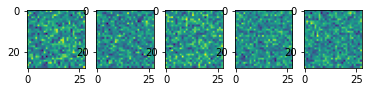

epoch: 500, [Discriminator :: d_loss: 0.562640], [ Generator :: loss: 8.911282]


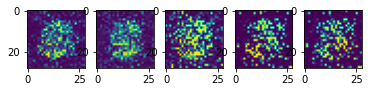

epoch: 1000, [Discriminator :: d_loss: 0.128523], [ Generator :: loss: 2.444174]


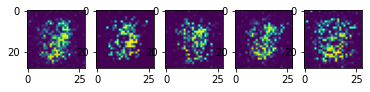

epoch: 1500, [Discriminator :: d_loss: 0.417893], [ Generator :: loss: 3.227857]


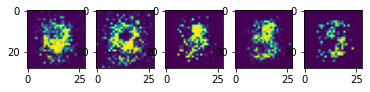

epoch: 2000, [Discriminator :: d_loss: 0.501574], [ Generator :: loss: 1.950952]


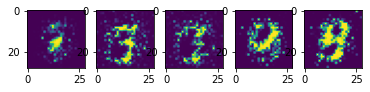

epoch: 2500, [Discriminator :: d_loss: 0.983484], [ Generator :: loss: 1.184198]


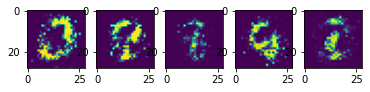

In [7]:
batch=32
for cnt in range(3000):
## train discriminator
  random_index =  np.random.randint(0, len(X_train) - batch//2)
  legit_images = X_train[random_index : random_index + batch//2].reshape(batch//2, 28, 28)
  gen_noise = np.random.normal(0, 1, (batch//2,100))
  syntetic_images = generator.predict(gen_noise)
  x_combined_batch = np.concatenate((legit_images, syntetic_images))
  y_combined_batch = np.concatenate((np.ones((batch//2, 1)), np.zeros((batch//2, 1))))
  d_loss = discriminator.train_on_batch(x_combined_batch, y_combined_batch)
# train generator
  noise = np.random.normal(0, 1, (batch,100))
  y_mislabled = np.ones((batch, 1))
  g_loss = adversarial.train_on_batch(noise, y_mislabled)
  if cnt%500==0:
    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))
    plotn(5)

## DCGAN

Deep Convolutional GAN - генератор и дискриминатор делаются свёрточными сетями

In [20]:
(X_train, _), (_, _) = keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32)-127.5) / 127.5
print(X_train.min(),X_train.max())

-1.0 1.0


In [42]:
generator = Sequential()
generator.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(128, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(64, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2DTranspose(1, kernel_size=3, padding="same"))
generator.add(Activation("tanh"))

optimizer = keras.optimizers.Adam(0.0001) #, 0.5)

generator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
generator.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_38 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_21 (Activation)   (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 28, 28, 128)     

In [0]:
discriminator = Sequential()

discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=optimizer)

In [0]:
discriminator.trainable = False
adversarial = Sequential()
adversarial.add(generator)
adversarial.add(discriminator)
adversarial.compile(loss='binary_crossentropy', optimizer=optimizer)

epoch: 0, [Discriminator :: d_loss: 0.000036], [ Generator :: loss: 10.730694]


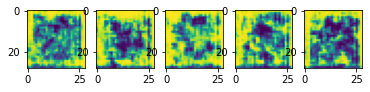

epoch: 100, [Discriminator :: d_loss: 0.011119], [ Generator :: loss: 3.941202]


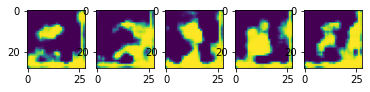

epoch: 200, [Discriminator :: d_loss: 0.134879], [ Generator :: loss: 1.294029]


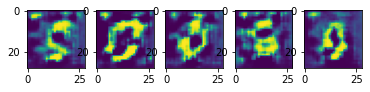

epoch: 300, [Discriminator :: d_loss: 0.064335], [ Generator :: loss: 1.228413]


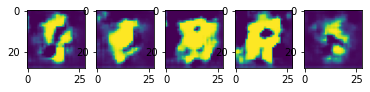

epoch: 400, [Discriminator :: d_loss: 0.159396], [ Generator :: loss: 0.598520]


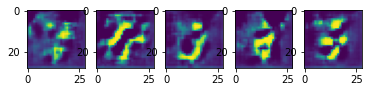

epoch: 500, [Discriminator :: d_loss: 0.193867], [ Generator :: loss: 0.838761]


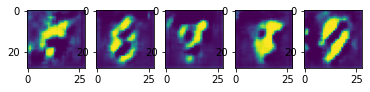

epoch: 600, [Discriminator :: d_loss: 0.047727], [ Generator :: loss: 0.451752]


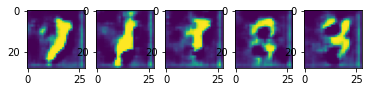

epoch: 700, [Discriminator :: d_loss: 0.181621], [ Generator :: loss: 1.190541]


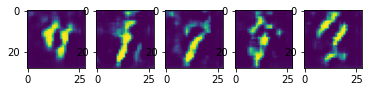

epoch: 800, [Discriminator :: d_loss: 0.365490], [ Generator :: loss: 1.676346]


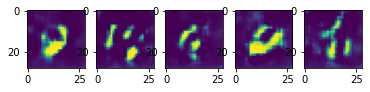

epoch: 900, [Discriminator :: d_loss: 0.434383], [ Generator :: loss: 0.945727]


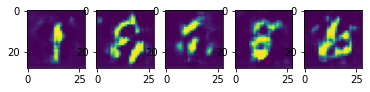

In [46]:
batch=32
y_labeled = np.ones((batch, 1))
y_mislabeled = np.zeros((batch, 1))
for cnt in range(1000):
## train discriminator
  random_index =  np.random.randint(0, len(X_train) - batch)
  legit_images = X_train[random_index : random_index + batch].reshape(batch, 28, 28, 1)
  gen_noise = np.random.normal(0, 1, (batch,100))
  syntetic_images = generator.predict(gen_noise)
  d_loss_1 = discriminator.train_on_batch(legit_images, y_labeled)
  d_loss_2 = discriminator.train_on_batch(syntetic_images, y_mislabeled)
  d_loss = 0.5*np.add(d_loss_1,d_loss_2)
# train generator
  g_loss = adversarial.train_on_batch(gen_noise, y_labeled)
  if cnt%100==0:
    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss, g_loss))
    plotn(5)

## Полезные ссылки 

* [Примеры реализации разных типов GAN на Keras](https://github.com/eriklindernoren/Keras-GAN)